# Interpolation with Autoregressive Model

In this project, we will interpolate missing values from a time series using autoregressive model. Considering that we have two systems of linear equations for X and error, we will solve least squares problem for A coefficients fixing X, and for missing X values fixing A in an alternating manner. 

In [1]:
flights = csvread('flights.csv');
# discard headers
T = flights(2:end, 1); # times
X = flights(2:end, 2); # values
X_size = size(X, 1);
# ignore zero values (for a better plot)
X(X == 0) = NaN;
X_orig = X;

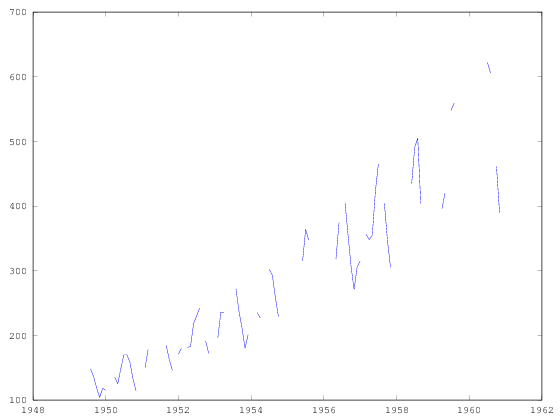

In [2]:
figure;
p1 = plot(T, X);

In [3]:
M = 4;
# missing indices
X_mi_i = find(isnan(X));
# observed indices
X_ob_i = find(not(isnan(X)));
X_ob = X(X_ob_i);

In [4]:
# set initial values for missing values
# randomly or via interpolating
# use normal distribution
mu = mean(X_ob);
sigma = std(X_ob);
X(X_mi_i) = normrnd(mu, sigma, size(X_mi_i));
# TODO: interpolate missing values
X_orig_filled = X;

Before starting to the iteration, we need to set values for missing values. We can assign zeros for all, we can assign randomly, or we can use interpolation to make a educated guess. 

It turns out that, we can get good results with randomly assigned values, thus we haven't tried with interpolation.

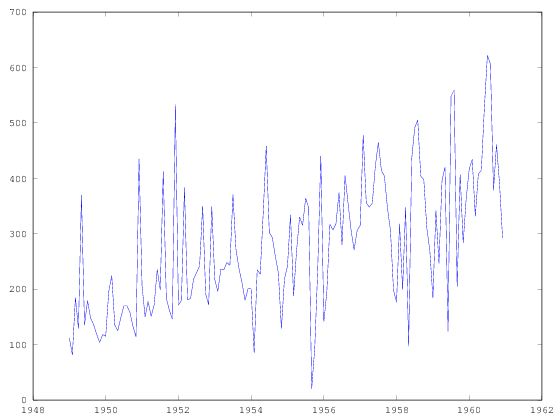

In [5]:
plot(T, X);

We will use reduced QR for solving the least squares problem

In [6]:
function A = solve(G, X)
    [Q, R] = qr(G, '0'); # reduced qr
    A = R \ (Q' * X);
end

In [7]:
# We iteratively construct G_X and G_A
for i = 1:20

    # Init G_X
    G_X = zeros(X_size - M, M);
    
    # Populate G_X
    for j = 1:(X_size - M)
        for k = 1:M
            G_X(j, k) = X(M + j - k);
        end
    end
    
    # Solve for A
    A = solve(G_X, X(M+1 : end));
    
    # Init G_A
    G_A = zeros(X_size - M, X_size);
    
    # Populate G_A
    for j = 1:(X_size - M)
        for k = 1:M
            G_A(j, j+k-1) = A(M+1-k);
        end
        # add -1 values
        G_A(j, j+M) = -1;
    end
    
    # G_A_miss has columns for only missing values
    # G_A_obs has columns for only observed values
    G_A_miss = G_A(:, X_mi_i);
    G_A_obs = G_A(:, X_ob_i);
    
    # Solve for X_mi
    X_mi = solve(G_A_miss, -1 .* (G_A_obs * X_ob));
    
    # fill missing values of X
    X(X_mi_i) = X_mi;
end

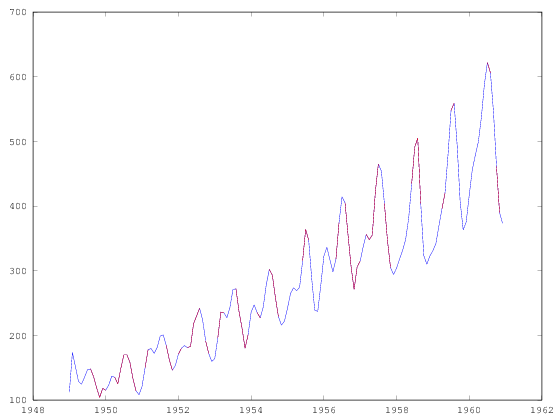

In [8]:
plot(T, X);
hold on;
plot(T, X_orig, 'r');

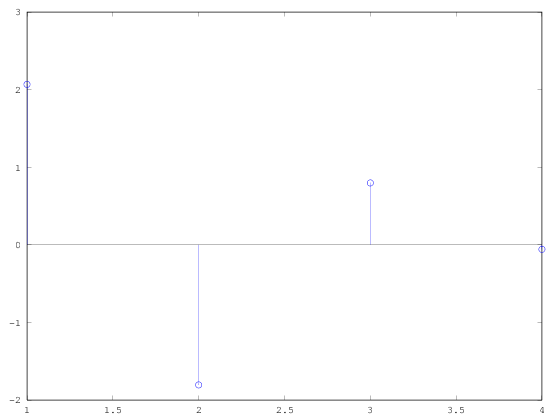

In [9]:
stem(A);

### Bonus

Considering that we have a time series, it might be a good idea to take time into account for systems of linear equations.

In [22]:
M = 5;

# Use filled X vector from previous part
X = X_orig_filled;

# We iteratively construct G_X and G_A
for i = 1:20

    # Init G_X
    # now we have 2 more columns
    G_X = zeros(X_size - M, M + 2);
    
    # Populate G_X
    for j = 1:(X_size - M)
        for k = 1:M
            G_X(j, k) = X(M + j - k);
        end
    end
    # set newly added columns
    G_X(:, M+1) = M+1 : X_size; # time values
    G_X(:, M+2) = 1;
    
    # Solve for A
    A = solve(G_X, X(M+1 : end));
    
    # Init G_A
    G_A = zeros(X_size - M, X_size);
    
    # Populate G_A
    for j = 1:(X_size - M)
        for k = 1:M
            G_A(j, j+k-1) = A(M+1-k);
        end
        G_A(j, j+M) = -1;
    end
    
    # G_A_miss has columns for only missing values
    # G_A_obs has columns for only observed values
    G_A_miss = G_A(:, X_mi_i);
    G_A_obs = G_A(:, X_ob_i);
    # Solve for X_mi
    # Add c * {time values} + d
    X_mi = solve(G_A_miss, -1 .* (G_A_obs * X_ob + (A(M+1) * (M+1 : X_size)') + A(M+2)));
    # fill missing values of X
    X(X_mi_i) = X_mi;
end

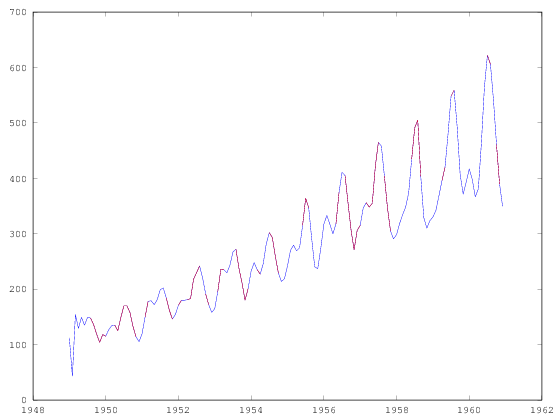

In [23]:
plot(T, X);
hold on;
plot(T, X_orig, 'r')

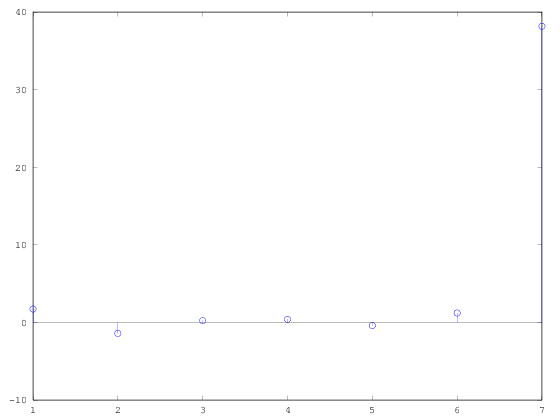

In [24]:
stem(A);